In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import os
np.random.seed(1)

In [2]:
from scipy.stats import ttest_rel, ttest_ind

# Introduction

Table of Content
- [Error analysis and Uncertainty](#Error-analysis-and-Uncertainty)
- [Data augmentation](#Comparison-with-and-without-data-augmentation)
- [RNTL vs Other layers](#Comparison-of-RNTL-vs-Other-Layers)
- [Glaucoma vs HC](#Comparison-of-Glaucoma-vs-Health-Controls)
- [Manual vs model segmentation](#Comparison-between-manual-and-model-segmentation)
- [TBD](#Repeatability)


To start with, this notebook reads in a `results.xlsx` file where:
* Each xlsx file has three sheets, one per class
* Each xlsx file has N rows, one per unique image 
* `pixels_pred`: percent of pixels labeled as that class in the model segmentation
* `pixels_true`: percent of pixels labeled as that class in the manual segmentation
* `thickness_pred`: average of vertical thickness of that class (measured as number of pixels) in the model segmentation
* `thickness_true`: paverage of vertical thickness of that class (measured as number of pixels) in the manual segmentation
* `dice`
* `auc`
* `accuracy`
* `jaccard`


# Setup: find best result model

In [80]:
# find the model with best test DICE for class 2
model_directory  = '../models/BaseUnet_Aug_5layers'

folders, dices_test, dices_val = [], [], []

# iterate over files in that directory
for model_folder in os.listdir(model_directory):
    f_val = os.path.join(model_directory, model_folder, "validation_report.xlsx")
    f_test = os.path.join(model_directory, model_folder, "test_report.xlsx")
    if os.path.isfile(f_test):
        result2 = pd.read_excel(f_test, sheet_name="class2", index_col=0)
        result1 = pd.read_excel(f_val, sheet_name="class2", index_col=0)
        folders.append(model_folder)
        dices_test.append(result2.loc['Mean', 'dice'])
        dices_val.append(result1.loc['Mean', 'dice'])

# find best model 
idx = np.argmax(np.asarray(dices_test))
print("Best model folder:", folders[idx])
print(" Test DICE class 2:", dices_test[idx], " Validation DICE class 2", dices_val[idx]) 

# read in the report of the best model 
file_name = os.path.join(model_directory, folders[idx], "test_report.xlsx")
result1 = pd.read_excel(file_name, sheet_name="class1", index_col=0)
result2 = pd.read_excel(file_name, sheet_name="class2", index_col=0)

#Validation
file_name = os.path.join(model_directory, folders[idx], "validation_report.xlsx")
result1_val = pd.read_excel(file_name, sheet_name="class1", index_col=0)
result2_val = pd.read_excel(file_name, sheet_name="class2", index_col=0)

# remove the row with mean and std
result1 = result1.iloc[:-2,:]
result2 = result2.iloc[:-2,:]
result1_val = result1_val.iloc[:-2,:]
result2_val = result2_val.iloc[:-2,:]

Best model folder: Model_2022-05-01 09:25:25.844974
 Test DICE class 2: 0.8246644660830498  Validation DICE class 2 0.741597393527627


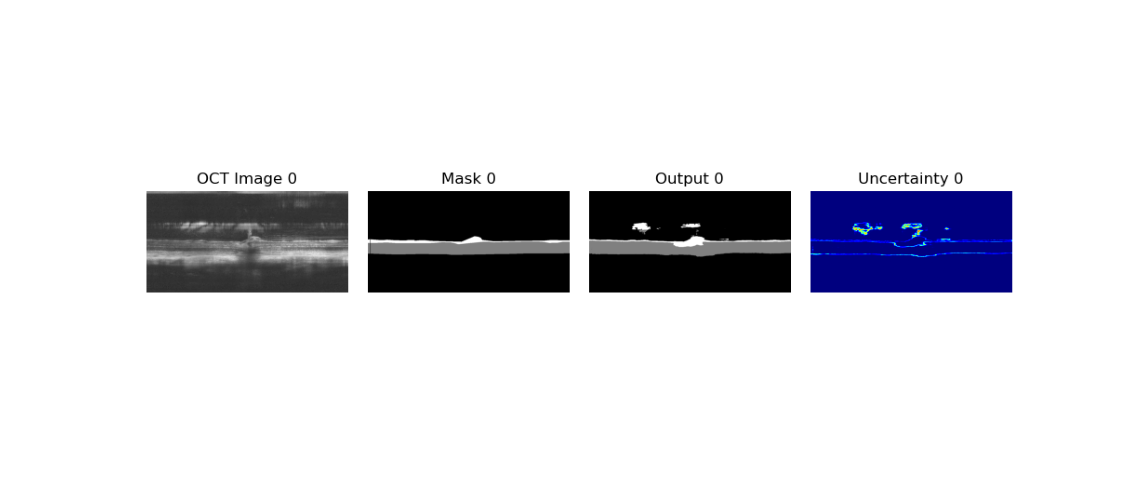

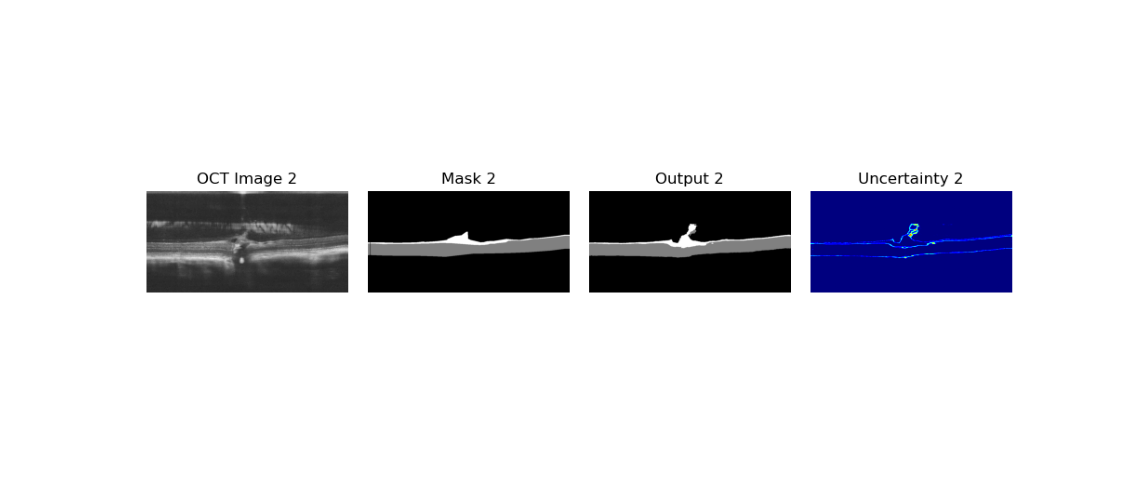

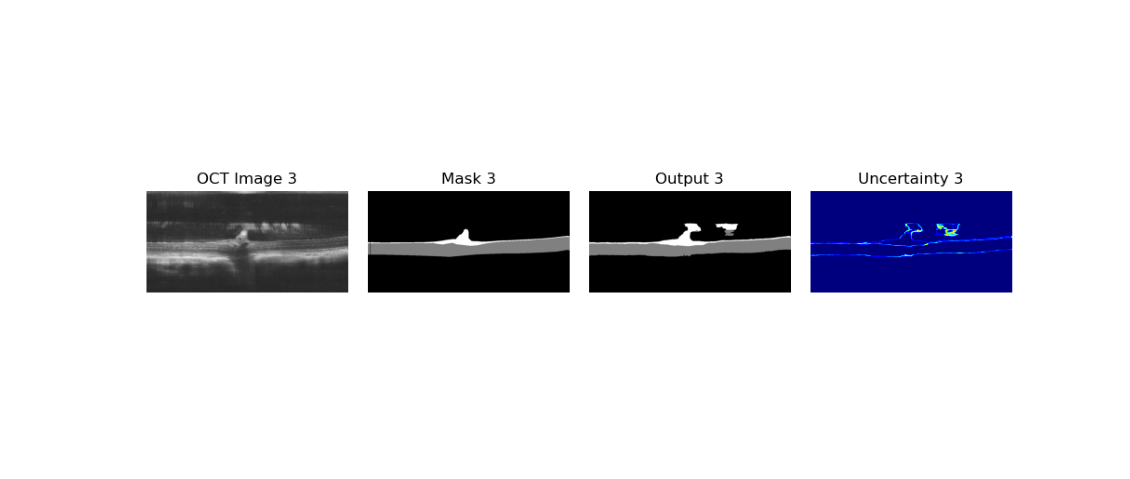

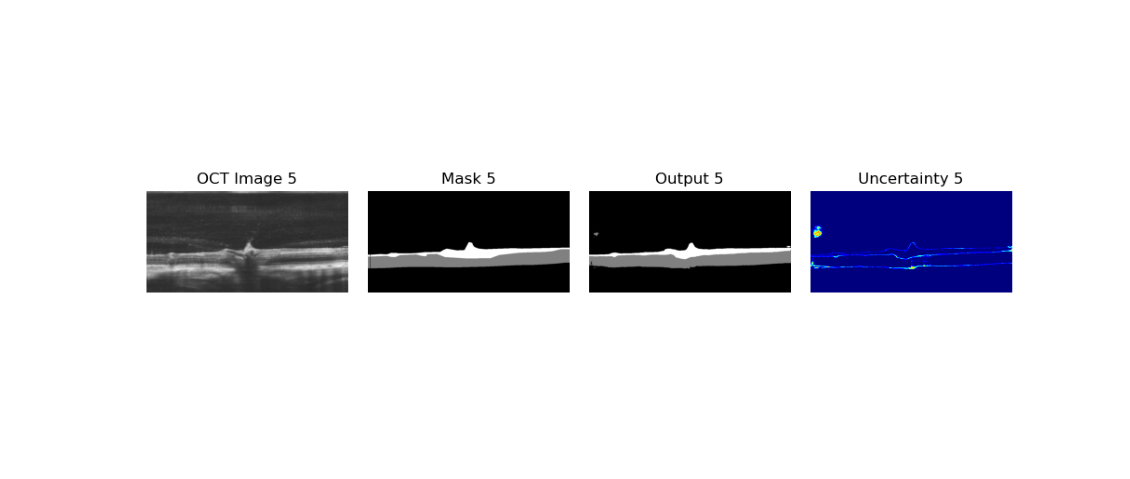

In [76]:
# visualize some images of the best model
for i in range(10):
    image_file_name = os.path.join(model_directory, folders[idx], "Testing-"+str(i)+".png")
    if os.path.isfile(image_file_name):
        image = plt.imread(image_file_name) 
        plt.figure(figsize=(20,60))
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [77]:
# function to read and visualize an image
def visualize_original_image(idx, original_image_folder = "../data/full_window/"):
    x_test = plt.imread(original_image_folder + "test_images/image_" + idx + ".tiff")
    y_test = plt.imread(original_image_folder + "test_labels/label_" + idx + ".tiff")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,20))
    axes[0].axis("off")
    axes[0].imshow(x_test[:,:,0], cmap="gray")
    print(np.min(x_test[:,:,0]), np.max(x_test[:,:,0]), np.min(x_test[:,:,0]), np.std(x_test[:,:,0]))
    axes[0].set_title('OCT image ' + idx)
    axes[1].axis("off")
    axes[1].imshow(y_test, cmap="gray")
    axes[1].set_title("Mask " + idx)
    plt.show()

# Error analysis and Uncertainty

Observations:
* The distribution of DICE is very left-skewed: Majority of images have high DICE and few images have very bad segmentation. The images that have bad segmentation are likely to be because of ....
* T-test shows that the model's accuracy for certain images is significantly higher than the images that the model is less certain

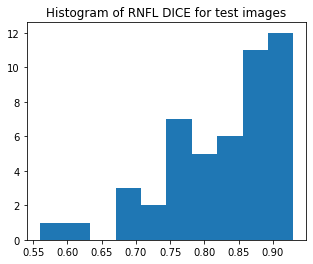

Average: 0.8246644660830498
Worst image: 32
0 6 0 1.0385968451146494


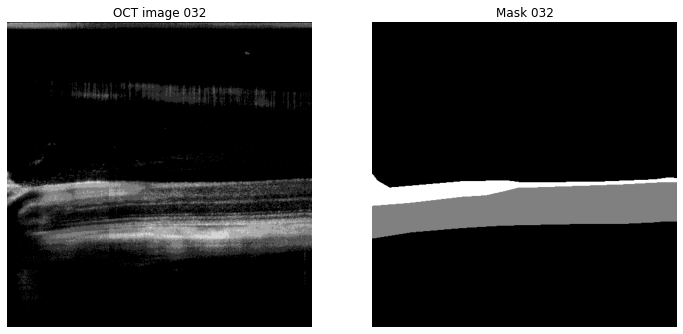

In [81]:
metrics = result2['dice'] 

# view histogram
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(metrics)  # to exclude mean and std
plt.title("Histogram of RNFL DICE for test images")
plt.show()

# view which image had worst dice
idx = np.argmin(metrics)
print("Average:", np.mean(metrics))
print("Worst image:", idx)

# visualize image
visualize_original_image('0'+str(idx), original_image_folder = "../data/sliding_window/")

Same analysis for uncertainty.
T-test compares if the accuracy of certain images is sigificantly higher than that of uncertain regions.

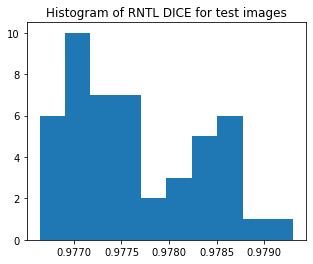

Average: 0.9776294181744257
Worst image: 21
0 6 0 0.9123531042759002


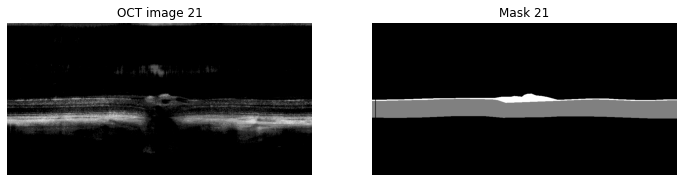

In [83]:
metrics = result2['uncertainty'] # uncertainty

# view histogram
plt.rcParams["figure.figsize"] = (5,4)
plt.hist(metrics)  # to exclude mean and std
plt.title("Histogram of RNTL DICE for test images")
plt.show()

# view which image had worst dice
idx = np.argmin(metrics)
print("Average:", np.mean(metrics))
print("Worst image:", idx)

# visualize image
visualize_original_image(str(idx), original_image_folder = "../data/full_window/")

In [97]:
thd = np.mean(metrics) + np.std(metrics)
result2['uncertain'] = (result2['uncertainty'] >= thd).astype(int)

print("Number of certain images:", result2.query("uncertain==0").shape[0])
print("Number of uncertain images:", result2.query("uncertain>0").shape[0])
ttest_ind(result2.query("uncertain>0")['dice'], 
          result2.query("uncertain==0")['dice'])

Number of certain images: 39
Number of uncertain images: 9


Ttest_indResult(statistic=-2.134097207359522, pvalue=0.03819774212476001)

In [101]:
result2[['dice', 'uncertain']].groupby("uncertain").mean()

,dice
uncertain,
0,0.836680
1,0.772596


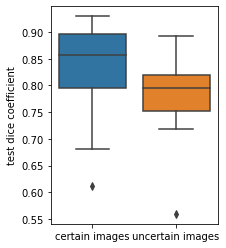

In [94]:
# boxplot to visualize accuracy of glaucoma vs HC
plt.rcParams["figure.figsize"] = (3,4)
g = sns.boxplot(x='uncertain', y='dice', data=result2)
g.set_xticklabels(['certain images', 'uncertain images'])
plt.xlabel("")
plt.ylabel("test dice coefficient")
plt.show()

In [68]:
# TODO: this uncertainty is the average of entire image so include background. Mask uncertainty for the class 

# Comparison of RNTL vs Other Layers

Observations: 
* layer 2 have a lower accuracy than other layers
* layer 2 is thinner (proportion of pixels within image is 3%'; within retina is 20%)

In [121]:
# compute "CVI; a commonly used metric that quantifies the ratio of the luminal area to the total choroidal area in a binarized OCT image"
result2['CVI_true'] = result2['pixels_true'] / (result1['pixels_true'] + result2['pixels_true'])
result2['CVI_pred'] = result2['pixels_pred'] / (result1['pixels_pred'] + result2['pixels_pred'])
result2_val['CVI_true'] = result2_val['pixels_true'] / (result1_val['pixels_true'] + result2_val['pixels_true'])
result2_val['CVI_pred'] = result2_val['pixels_pred'] / (result1_val['pixels_pred'] + result2_val['pixels_pred'])

In [103]:
result1.mean()

dice                0.937374
auc                 0.968006
accuracy            0.986164
jaccard             0.883199
thickness_pred    113.308919
thickness_true    114.887451
pixels_pred         0.110653
pixels_true         0.112195
uncertainty         0.977629
glaucoma            0.916667
dtype: float64

In [104]:
result2.mean()

dice               0.824664
auc                0.897715
accuracy           0.990477
jaccard            0.709664
thickness_pred    31.102173
thickness_true    29.416219
pixels_pred        0.030373
pixels_true        0.028727
uncertainty        0.977629
glaucoma           0.916667
uncertain          0.187500
CVI_true           0.199506
CVI_pred           0.212685
dtype: float64

In [105]:
result1_val.mean()

dice                0.868095
auc                 0.940359
accuracy            0.976640
jaccard             0.775964
thickness_pred     98.365479
thickness_true    103.555461
pixels_pred         0.096060
pixels_true         0.101128
uncertainty         0.978343
glaucoma            0.500000
dtype: float64

In [106]:
result2_val.mean()

dice               0.741597
auc                0.862385
accuracy           0.985957
jaccard            0.604015
thickness_pred    30.534220
thickness_true    28.181844
pixels_pred        0.029819
pixels_true        0.027521
uncertainty        0.978343
glaucoma           0.500000
dtype: float64

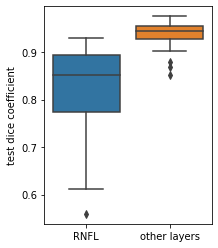

In [107]:
# boxplot to visualize accuracy of glaucoma vs HC
t = pd.concat((result2['dice'], result1['dice']), axis=1)
t.columns = ['layer1', 'layer2']
g = sns.boxplot(data=t)
g.set_xticklabels(['RNFL', 'other layers'])
plt.xlabel("")
plt.ylabel("test dice coefficient")
plt.show()

# Comparison of with vs without data augmentation

Observations
* The overall dice improved from 0.8144 to 0.8246
* Paired t-test shows using data augmentation significantly improved the overall DICE. Specifically, it improved for glaucoma patients

In [108]:
# find the model with best test DICE for class 2
model_directory  = '../models/BaseUnet_Aug_5layers'

folders, dices_test, dices_val = [], [], []

# iterate over files in that directory
for model_folder in os.listdir(model_directory):
    f_val = os.path.join(model_directory, model_folder, "validation_report.xlsx")
    f_test = os.path.join(model_directory, model_folder, "test_report.xlsx")
    if os.path.isfile(f_test):
        result2_aug = pd.read_excel(f_test, sheet_name="class2", index_col=0)
        result1_aug = pd.read_excel(f_val, sheet_name="class2", index_col=0)
        folders.append(model_folder)
        dices_test.append(result2_aug.loc['Mean', 'dice'])
        dices_val.append(result1_aug.loc['Mean', 'dice'])

# find best model 
idx = np.argmax(np.asarray(dices_test))
print("Best model folder:", folders[idx])
print(" Test DICE class 2:", dices_test[idx], " Validation DICE class 2", dices_val[idx]) 

# read in the report of the best model 
file_name = os.path.join(model_directory, folders[idx], "test_report.xlsx")
result1_aug = pd.read_excel(file_name, sheet_name="class1", index_col=0)
result2_aug = pd.read_excel(file_name, sheet_name="class2", index_col=0)

# remove the row with mean and std
result1_aug = result1_aug.iloc[:-2,:]
result2_aug = result2_aug.iloc[:-2,:]

Best model folder: Model_2022-05-01 09:25:25.844974
 Test DICE class 2: 0.8246644660830498  Validation DICE class 2 0.741597393527627


In [109]:
# Paired t-test if augmented data is better (YES!!!!)
ttest_rel(result2['dice'], 
          result2_aug['dice'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [110]:
# Paired t-test if augmented data is better for HC 
ttest_rel(result2.query("glaucoma==0")['dice'], 
          result2_aug.query("glaucoma==0")['dice'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [111]:
# Paired t-test if augmented data is better for glaucoma 
ttest_rel(result2.query("glaucoma==1")['dice'], 
          result2_aug.query("glaucoma==1")['dice'])

Ttest_relResult(statistic=nan, pvalue=nan)

# Comparison of Glaucoma vs Health Controls

Observations
* Test data is imbalanced: only 4 HC and 44 glaucoma, compared to validation daga with 50% of glaucoma and training  data with xx%
* Glaucoma patients have a lower accuracy compared to HC. However, the number of glaucoma patients is too small to be able to do a formal hypothesis testing

To do: 
- Add this analysis with validation.

In [112]:
result2.groupby("glaucoma").size()

glaucoma
0.0     4
1.0    44
dtype: int64

In [113]:
# Class-wise accuracy 
result2.groupby("glaucoma").mean()

,dice,auc,accuracy,jaccard,thickness_pred,thickness_true,pixels_pred,pixels_true,uncertainty,uncertain,CVI_true,CVI_pred
glaucoma,,,,,,,,,,,,
0.0,0.874841,0.917634,0.991931,0.777699,34.667480,31.652344,0.033855,0.030910,0.97718,0.000000,0.207504,0.235265
1.0,0.820103,0.895904,0.990344,0.703479,30.778054,29.212935,0.030057,0.028528,0.97767,0.204545,0.198779,0.210633


In [114]:
# T-test to compare if accuracy of glaucoma is less (4 subjects is too small for the test to be valid) 
ttest_ind(result2.query("glaucoma==0")['dice'], 
          result2.query("glaucoma==1")['dice'])

Ttest_indResult(statistic=1.2520885981287366, pvalue=0.2168666431837262)

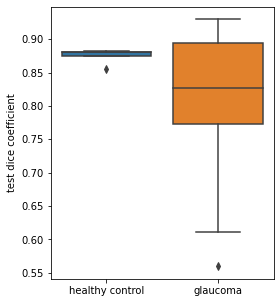

In [151]:
# boxplot to visualize accuracy of glaucoma vs HC
plt.rcParams["figure.figsize"] = (4,5)
g = sns.boxplot(x="glaucoma", y="dice",  data=result2)
g.set_xticklabels(['healthy control', 'glaucoma'])
plt.xlabel("")
plt.ylabel("test dice coefficient")
plt.show()

In [69]:
# test if glaucoma subjects have more pixels than HC (4 subjects is too small for the test to be valid)
ttest_ind(result2.query("glaucoma==0")['pixels_true'], 
          result2.query("glaucoma==1")['pixels_true'])

Ttest_indResult(statistic=0.43529441760100573, pvalue=0.6653844009437141)

# Comparison between manual and model segmentation

Observations
* No significant difference in pixel counts between manual and model segmentation

## Paired-t test for equality of means of pixel counts


Paired t-test compares whether there is statistically significance between the number of pixels in a class in the manual and DL segmentations. 

In [70]:
ttest_rel(result2['pixels_true'], result2['pixels_pred'])

Ttest_relResult(statistic=-3.5968805322631754, pvalue=0.0007709704560154518)

Same test but only looking at health controls

In [71]:
ttest_rel(result2.query("glaucoma==0")['pixels_true'], 
          result2.query("glaucoma==0")['pixels_pred'])

Ttest_relResult(statistic=-0.8889600393757513, pvalue=0.4395089452637506)

Same test but only looking at glaucoma

In [72]:
ttest_rel(result2.query("glaucoma==1")['pixels_true'], 
          result2.query("glaucoma==1")['pixels_pred'])

Ttest_relResult(statistic=-3.4637548992760316, pvalue=0.0012185240841559115)

## Correlation plots of number of pixels per class or CVI

We can show the number of pixels per class per scan in an almond graph like this, one per each class across each set. This way it would allow us to see the relationship between both human and dl segmentations.

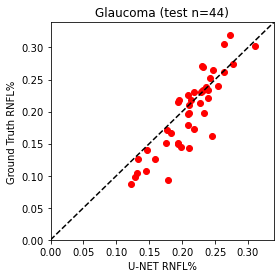

In [144]:
x1 = result2.query("glaucoma==1")['CVI_pred']
x2 = result2.query("glaucoma==1")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='r')
plt.ylabel("Ground Truth RNFL%")
plt.xlabel("U-NET RNFL%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("Glaucoma (test n=" + str(x1.shape[0]) + ")")
plt.show()

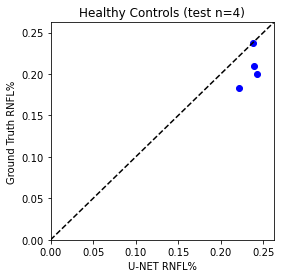

In [149]:
x1 = result2.query("glaucoma==0")['CVI_pred']
x2 = result2.query("glaucoma==0")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='b')
plt.ylabel("Ground Truth RNFL%")
plt.xlabel("U-NET RNFL%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("Healthy Controls (test n=" + str(x1.shape[0]) + ")")
plt.show()

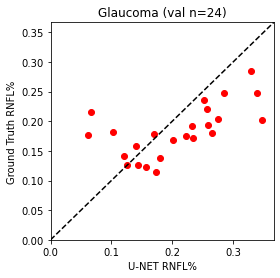

In [146]:
x1 = result2_val.query("glaucoma==1")['CVI_pred']
x2 = result2_val.query("glaucoma==1")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='r')
plt.ylabel("Ground Truth RNFL%")
plt.xlabel("U-NET RNFL%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("Glaucoma (val n=" + str(x1.shape[0]) + ")")
plt.show()

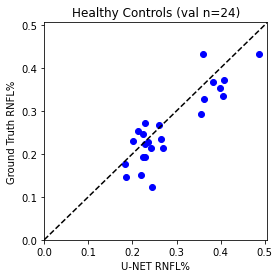

In [147]:
x1 = result2_val.query("glaucoma==0")['CVI_pred']
x2 = result2_val.query("glaucoma==0")['CVI_true']
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(x1, x2, c='b')
plt.ylabel("Ground Truth RNFL%")
plt.xlabel("U-NET RNFL%")
plt.axline((0, 0), linestyle='--', slope=1, color='black')
plt.xlim([0, max(max(x1),max(x2))+0.02])
plt.ylim([0, max(max(x1),max(x2))+0.02])
plt.title("Healthy Controls (val n=" + str(x1.shape[0]) + ")")
plt.show()

# Repeatability

Ref: https://doi.org/10.1167/tvst.11.2.23)

Taking into consideration that all the scans included in the data set have “follow-up” scans taken at the same visit aligned at the same retinal location, a repeatability analysis was also performed comparing the two scans collected at the same visit on each participant. The repeatability was calculated as the absolute difference in the proportion of pixels for each category, given by the following formula: 

$$
R = \frac{|P_1 - P_2|}{p} \times 100 
$$

where P1 and P2 are the number of correctly classified pixels for scans 1 and 2 respectively for a given category, p is the number of total pixels in an image (224 × 896 pixels), and R provides a repeatability metric given as a percentage difference between scans 1 and 2 for each category

In [75]:
patients = result2.shape[0] // 4
p = 1024*512 #CHECK TOTAL PIXELS IN IMAGE
Rs = []
mean_diff_pixels = []
for patient in range(patients):
    P1 = result2.loc[patient*4, 'accuracy'] * result2.loc[patient*4, 'pixels_true'] * p # pixels_true is percentage of pixels
    P2 = result2.loc[patient*4+1, 'accuracy'] * result2.loc[patient*4+1, 'pixels_true']* p
    P3 = result2.loc[patient*4+2, 'accuracy'] * result2.loc[patient*4+2, 'pixels_true']* p
    P4 = result2.loc[patient*4+3, 'accuracy'] * result2.loc[patient*4+3, 'pixels_true']* p
    R12 = np.abs(P1-P2) / p * 100
    R13 = np.abs(P1-P3) / p * 100
    R14 = np.abs(P1-P4) / p * 100
    R23 = np.abs(P2-P3) / p * 100
    R24 = np.abs(P2-P4) / p * 100
    R = np.mean([R12, R13, R14, R23, R24])
    Rs.append(R)
    mean_diff_pixels.append(R * p / 100)

In [76]:
Rs

[0.5319472326664254,
 0.2690409370552519,
 0.482905587996356,
 0.4082755841955074,
 0.26198138497420587,
 0.12886023643659414,
 0.8219271699636007,
 0.3736967915756396,
 0.5458531368640255,
 0.7668940930307141,
 0.4781731152615974,
 0.20621839474188133]

In [77]:
mean_diff_pixels

[2788.9355072021485,
 1410.549348068239,
 2531.816049194335,
 2140.5398948669417,
 1373.5369636535645,
 675.5987564086906,
 4309.265520858763,
 1959.2474346160895,
 2861.842494201662,
 4020.7337024688704,
 2507.0042625427236,
 1081.178297424315]

In [78]:
p

524288

In [96]:
import post_eval

ModuleNotFoundError: No module named 'torch'

In [92]:
sys.path.append("../")